# Random Forest

En general, los árboles de decisión son herramientas muy útiles para realizar predicciones y son bastante intuitivos cuando se visualiza el árbol, incluso en problemas con muchas dimensiones. Sin embargo, los árboles de decisión tienden a sobreajustarse (overfitting) a los datos de entrenamiento, especialmente si no se aplican técnicas de poda o regularización adecuadas. Esto significa que, a menudo, tienen un rendimiento deficiente en datos nuevos que no han visto durante el entrenamiento. 

Para mitigar este problema y mejorar la capacidad de generalización, se pueden utilizar técnicas de ensamblado, como los bosques aleatorios (random forests) y el gradiente impulsado por árboles (gradient boosting), que combinan múltiples árboles de decisión para obtener modelos más robustos y con mejor capacidad de generalización.

Para implementar una estrategia de Random Forest, es esencial construir varios árboles de decisión que sean diferentes entre sí. Este proceso se basa en dos principios fundamentales: la muestra aleatoria y la submuestra de características.

- **Muestra aleatoria (Bootstrap Sampling):** Cada árbol en el bosque se entrena utilizando una muestra aleatoria de los datos de entrenamiento, obtenida mediante un proceso llamado "bootstrap". Esto implica seleccionar aleatoriamente datos con reemplazo, lo que significa que algunos datos pueden aparecer más de una vez en la muestra de entrenamiento de un árbol, mientras que otros pueden no estar presentes.

- **Submuestra de características (Feature Randomness):** Durante la construcción de cada árbol, en cada división del nodo, se selecciona un subconjunto aleatorio de las características disponibles. Esto asegura que cada árbol no se base en todas las características y, por ende, reduce la correlación entre los árboles individuales.

Una vez que todos los árboles han sido entrenados, se promedian los resultados (en el caso de regresión) o se realiza una votación mayoritaria (en el caso de clasificación) para obtener el resultado final. Este enfoque ayuda a mejorar la precisión y la robustez del modelo, ya que combina las predicciones de múltiples árboles y reduce el riesgo de sobreajuste que podría ocurrir con un solo árbol de decisión.

Los parámetros importantes a controlar en un Random Forest son:

- **n_estimators:** Indica el número de árboles de decisión que se van a construir en el bosque. Un mayor número de estimadores generalmente mejora la robustez del modelo, pero también aumenta el tiempo de entrenamiento y la complejidad computacional.

- **n_samples:** Se refiere al número de muestras que se utilizan para entrenar cada árbol de decisión. Cada árbol se entrena utilizando una muestra aleatoria del dataset original, lo que puede resultar en que algunos datos se repitan varias veces en la muestra (bootstrap sampling) o se omitan por completo.

- **max_features:** Especifica el número máximo de características a considerar cuando se busca la mejor división en un nodo. Este parámetro es crucial para la aleatorización en el proceso de construcción de árboles. Si max_features es igual al número total de características (n_features), cada árbol considera todas las características en cada división, lo que puede llevar a árboles muy similares y, por ende, a menor diversidad en el modelo. Si max_features es mucho menor que n_features, se introduce más aleatoriedad, lo que suele mejorar la generalización del modelo pero puede hacer que algunos árboles sean muy diferentes entre sí. La elección de este parámetro debe ser balanceada para maximizar la diversidad y la eficacia del bosque. Como regla general es bueno utilizar max_features = sqrt(n_features) para clasificacion y max_features = log2(n_features) para regresion.



In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_blobs, load_breast_cancer, make_moons
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils import Bunch

In [7]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    # Define colors for each category
    color_cycle = ['#0000aa', '#ff2020', '#50ff50']  # Define specific colors

    # Handle the case where there is only one unique value
    if len(unique_y) == 1:
        single_color = color_cycle[0] if unique_y[0] == 0 else color_cycle[1]
        color_cycle = [single_color] * len(unique_y)

    for i, (yy, color) in enumerate(zip(unique_y, color_cycle)):
        mask = y == yy
        if c is None:
            current_color = color
        elif len(c) > 1:
            current_color = c[i]
        else:
            current_color = c
        
        if np.mean(colorConverter.to_rgb(current_color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, color=current_color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

In [8]:
def plot_tree_partition(X, y, tree, ax=None):
    cm3 = ListedColormap(['#0000aa', '#ff2020'])

    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm3, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)

    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [14]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,                      
                        cm=None, linewidth=None, threshold=None, linestyle="solid"):
    if cm is None:
        cm = ListedColormap(['#0000aa', '#ff2020'])
    
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


In [23]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

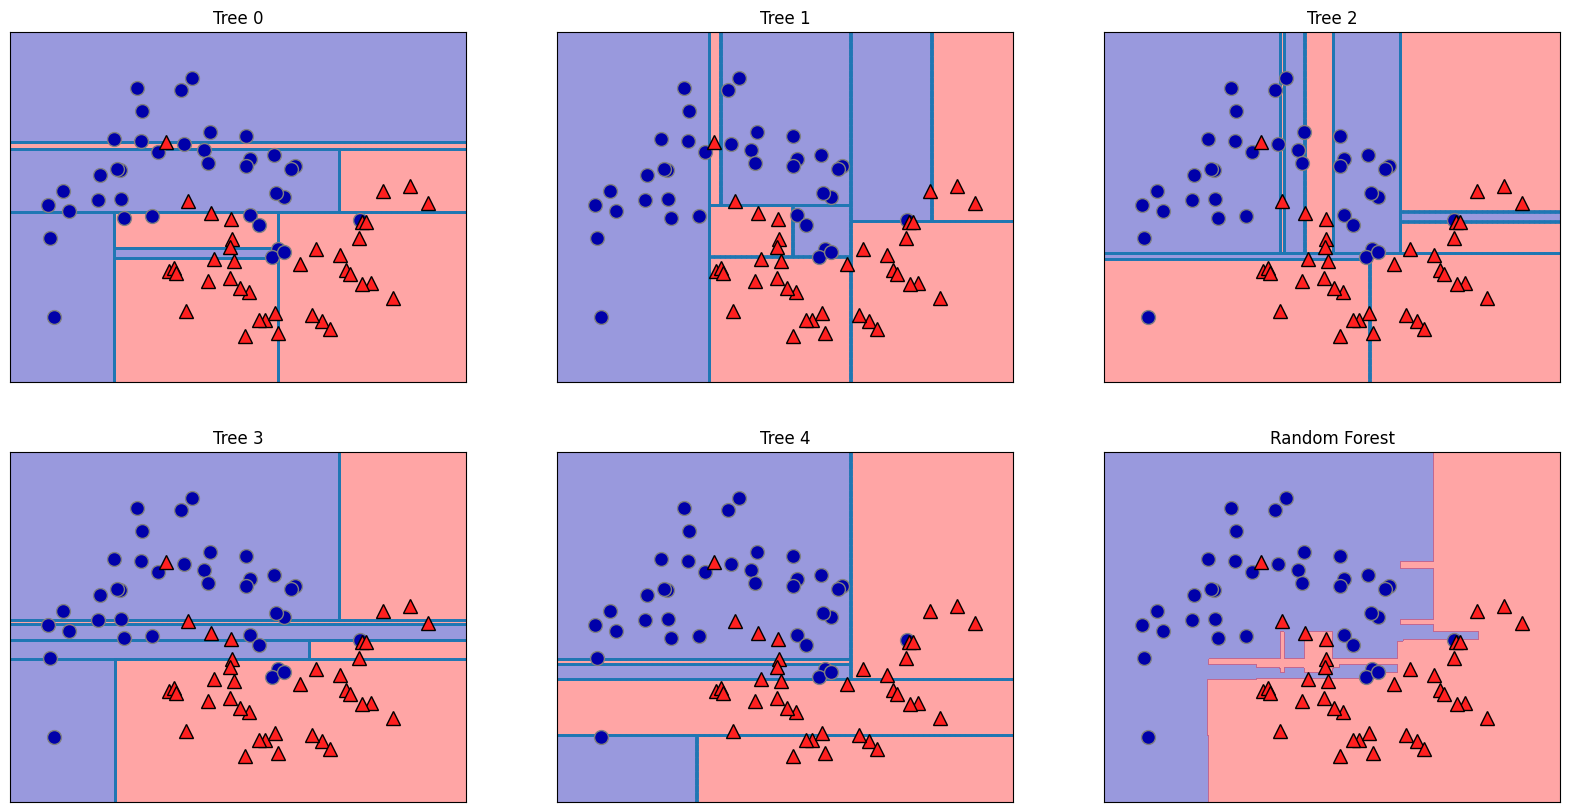

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    plot_tree_partition(X_train, y_train, tree, ax=ax)
    
plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

In [26]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


(-1.0, 30.0)

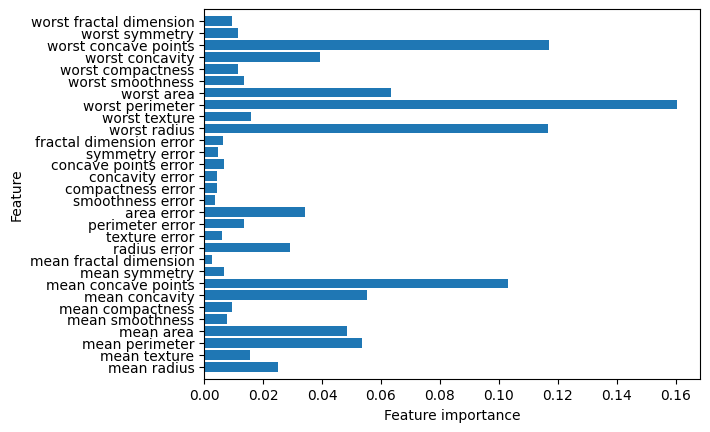

In [27]:
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)